In [12]:
import IPython.display as ipd
from scipy.io import wavfile
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import librosa
import librosa.display

DATA_DIR = '/Users/seonghoonjung/.kaggle/data/tensorflow-speech-recognition'
TRAIN_AUDIO_DIR = DATA_DIR + '/train/audio'


## 음성 파일 들어보기

In [11]:
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(TRAIN_AUDIO_DIR) + filename)
ipd.Audio(samples, rate=sample_rate)

## 스펙트로그램

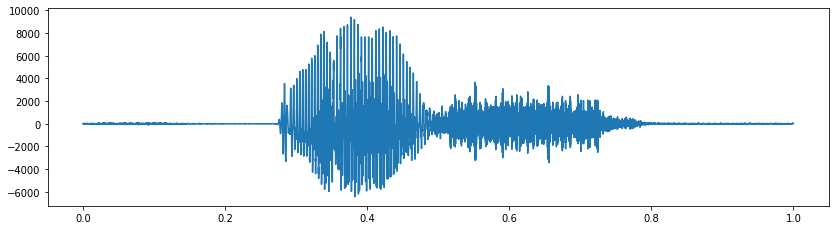

In [14]:
# 음성 파형
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.plot(np.linspace(0,sample_rate/len(samples), sample_rate), samples)

Text(0.5, 0, 'Seconds')

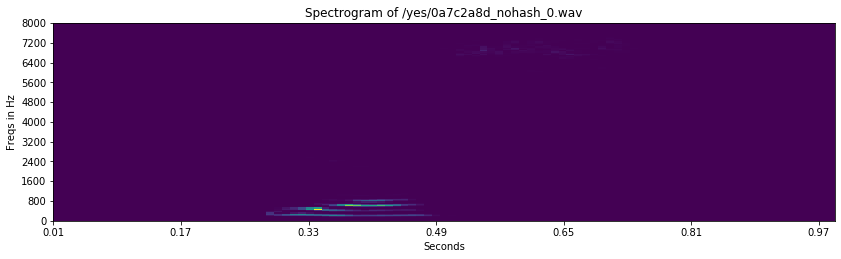

In [18]:
def specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size*sample_rate /1e3))
    noverlap = int(round(step_size*sample_rate / 1e3))
    
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    
    return freqs, times, spec.T.astype(np.float32)

freqs, times, spectrogram = specgram(samples, sample_rate)
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax1.set_yticks(freqs[::16])
ax1.set_xticks(times[::16])
ax1.set_title('Spectrogram of ' + filename)
ax1.set_ylabel('Freqs in Hz')
ax1.set_xlabel('Seconds')

### log-spectrogram

Text(0.5, 0, 'Seconds')

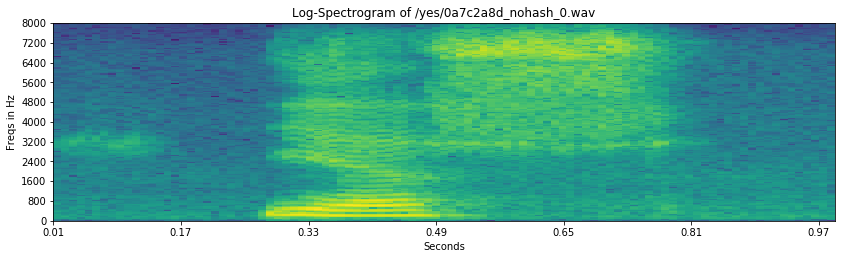

In [20]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size*sample_rate /1e3))
    noverlap = int(round(step_size*sample_rate / 1e3))
    
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    
    return freqs, times, np.log(spec.T.astype(np.float32) +eps)

freqs, times, log_spectrogram = log_specgram(samples, sample_rate)
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.imshow(log_spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax1.set_yticks(freqs[::16])
ax1.set_xticks(times[::16])
ax1.set_title('Log-Spectrogram of ' + filename)
ax1.set_ylabel('Freqs in Hz')
ax1.set_xlabel('Seconds')

### mel-spectrogram

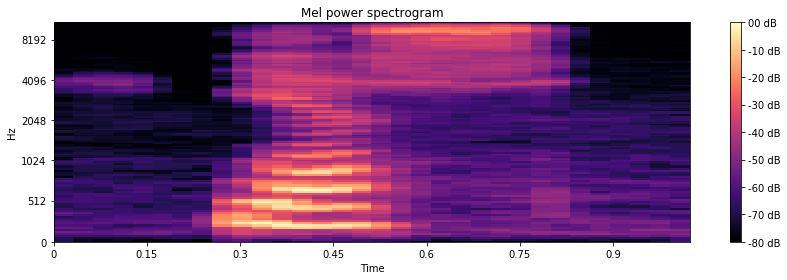

In [22]:
S = librosa.feature.melspectrogram(samples.astype(np.float16), sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

fig = plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%02.0f dB')
plt.tight_layout()

### MFCC

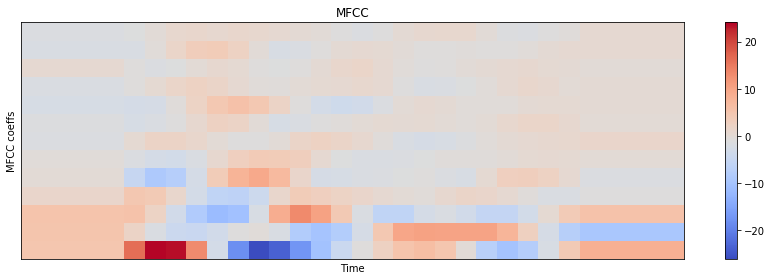

In [24]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

fig = plt.figure(figsize=(12,4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## 이상값 찾기 

* 음성 신호를 FFT로 변환한 후에, 
* PCA로 차원 축소  
* 눈으로 outlier 확인

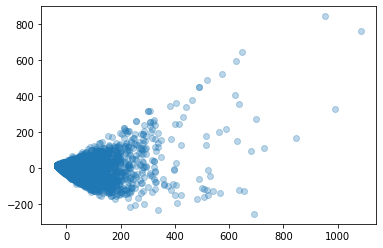

In [34]:
import numpy as np
import os
from scipy.fftpack import fft
from sklearn.decomposition import PCA

def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

TRAIN_AUDIO_DIR

dirs = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
fft_all = []
names = []

for direct in dirs:
    waves = [f for f in os.listdir(os.path.join(TRAIN_AUDIO_DIR+'/',direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(TRAIN_AUDIO_DIR+'/'+direct+'/'+wav)
        if samples.shape[0] != sample_rate: # if insufficient, then fill-zero
            samples = np.append(samples, np.zeros((sample_rate-samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct+'/'+wav)

fft_all = np.array(fft_all)

# 정규화 
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# PCA로 2차원으로 축소
pca = PCA(n_components=2)
fft_all = pca.fit_transform(fft_all)

# 축소된 데이터를 시각화 
plt.scatter(x=fft_all[:,0], y=fft_all[:,1], alpha=0.3)
    


In [35]:
for i in np.where(fft_all[:,0]>800)[0]:
    print(names[i])

yes/5165cf0a_nohash_0.wav
yes/e4b02540_nohash_0.wav
yes/617de221_nohash_1.wav
stop/de41f895_nohash_1.wav


In [40]:
filename = '/stop/de41f895_nohash_1.wav'
sample_rate, samples = wavfile.read(str(TRAIN_AUDIO_DIR) + filename)
ipd.Audio(samples, rate=sample_rate)

## 데이터 어그멘테이션

In [64]:
import IPython.display as ipd
from scipy.io import wavfile
import random

# 음성 데이터를 읽어온다.
filename = '/yes/0a7c2a8d_nohash_0.wav'
#filename = '/stop/de41f895_nohash_1.wav'
sample_rate, samples = wavfile.read(str(TRAIN_AUDIO_DIR) + filename)

# 음성 위치를 랜덤하게 이동
shift_range = random.randint(200,800)
shift = sample_rate*100 // 1000
shift = random.randint(-shift,shift)
a = -min(0,shift)
b = max(0,shift)
sample_aug = np.pad(samples, (a,b), "constant").astype(np.float16)
sample_aug = sample_aug[:len(sample_aug) - a] if a else sample_aug[b:]

# 제공된 배경 소음 중, 랜덤으로 1초 가량의 소음을 추가한다
max_ratio = random.choice([0.1, 0.5, 1, 1.5])
noise_filenames = [f for f in os.listdir(os.path.join(TRAIN_DIR+'/', '_background_noise_')) if f.endswith('.wav')]
noise_filename = noise_filenames[random.randint(0, len(noise_filenames)-1)]
_, noise_samples = wavfile.read(TRAIN_DIR+'/' + '_background_noise_/' + noise_filename)
start_idx = random.randint(0, len(noise_samples) - 1 - sample_rate)
noise_samples = noise_samples[start_idx:(start_idx + sample_rate)]
max_ratio = random.choice([0.1, 0.5, 1, 1.5])
sample_aug += max_ratio * random.random() * noise_samples.astype(np.float16)

# 파형의 높이를 스케일링한다
scale = random.uniform(0.75, 1.25)
sample_aug *= scale

# Data Augmentation을 취한 음성 파일을 들어본다
ipd.Audio(sample_aug, rate=sample_rate)



/Users/seonghoonjung/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:23: WavFileWarning: Chunk (non-data) not understood, skipping it.


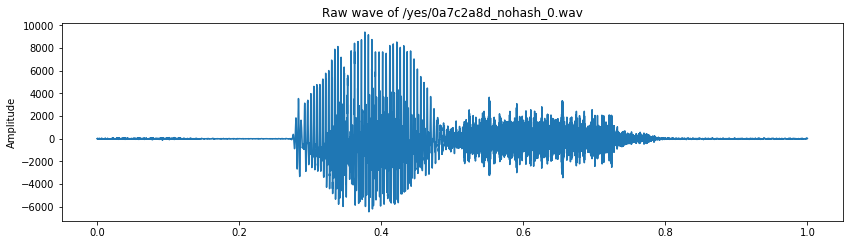

In [61]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

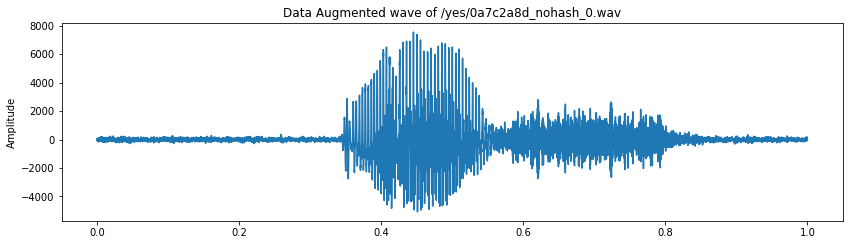

In [65]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Data Augmented wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(sample_aug), sample_rate), sample_aug)